In [1]:
import numpy as np

from scipy.stats import multivariate_normal

from sklearn.base import ClassifierMixin
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC

In [2]:
from time import time
from typing import List
from itertools import product

In [3]:
from utils import *

In [4]:
traces_path = "..\\acquisition\\50000_same_varying-mask_nullmask_maskshuffle\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Same-And-Varying-Multiple-Defenses.mat"
key_path = "..\\acquisition\\50000_same_varying-mask_nullmask_maskshuffle\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Same-And-Varying-Multiple-Defenses.log"

In [5]:
data_loader = EntireTraceIterator(traces_path, key_path, nr_populations=2, nr_scenarios=1)

In [6]:
EARLIEST_ROUND = 0

In [7]:
KEY_ALPHABET = list(range(16))

## Profiling stage

#### SOST

In [8]:
def sost_masks_card_m_v_y_subsample(seeds_sub: np.ndarray, key_shares_sub: np.ndarray, traces_sub: np.ndarray):
    assert seeds_sub.shape[0] == traces_sub.shape[0]
    assert key_shares_sub.shape == (KEY_WIDTH_B4, NR_SHARES)
    card_g = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET), 1), dtype=np.int32)
    m = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET), traces_sub.shape[1]), dtype=np.float32)
    v = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET), traces_sub.shape[1]), dtype=np.float64)
    y = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, traces_sub.shape[0]), dtype=int)

    for seed, (trace_idx, trace) in zip(seeds_sub, enumerate(traces_sub)):
        indices, whitening = chacha_random_b4(seed)

        for round_idx in range(EARLIEST_ROUND, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
            for block_idx in range(BLOCK_WIDTH_B4):
                keyround_index = round_idx * BLOCK_WIDTH_B4 + block_idx

                shares = np.zeros(NR_SHARES, dtype=int)
                for share_idx in range(shares.shape[0] - 1):
                    shares[share_idx] = key_shares_sub[indices[keyround_index], share_idx]
                shares[-1] = (key_shares_sub[indices[keyround_index], -1] + whitening[keyround_index]) % 16

                for share_idx, share in enumerate(shares):
                    card_g[round_idx, block_idx, share_idx, share, 0] += 1
                    m[round_idx, block_idx, share_idx, share] += trace
                    v[round_idx, block_idx, share_idx, share] += np.square(trace.astype(np.float64))

                    y[round_idx, block_idx, share_idx, trace_idx] = share
    
    return card_g, m, v, y

In [9]:
def sost_combine_subsamples(card_g: np.ndarray, m: np.ndarray, v: np.ndarray) -> np.ndarray:
    assert card_g.shape == (KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET), 1)
    assert m.ndim == 5 and m.shape[:4] == card_g.shape[:4]
    assert m.shape == v.shape
    f = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, m.shape[-1]), dtype=np.float32)

    m /= card_g
    v = (v - card_g * m * m) / (card_g - 1)

    for i in range(len(KEY_ALPHABET)):
        for j in range(i + 1, len(KEY_ALPHABET)):
            num = m[:, :, :, i] - m[:, :, :, j]
            den = np.sqrt(v[:, :, :, i] / card_g[:, :, :, i] + v[:, :, :, j] / card_g[:, :, :, j])
            f += np.square(num / den)
    
    return f

In [10]:
def n_largest_values_separated_by_cycle(f: np.ndarray, n: int, cycle_length: int) -> np.ndarray:
    interesting_points_per_index = np.zeros((f.shape[0], f.shape[1], f.shape[2], n), dtype=int)
    sorted_strengths = np.argsort(f, axis=3)[:, :, :, ::-1]

    for round_idx in range(EARLIEST_ROUND, sorted_strengths.shape[0]):
        for block_idx in range(sorted_strengths.shape[1]):
            for share_idx in range(sorted_strengths.shape[2]):
                largest_indices = []
                for ind in sorted_strengths[round_idx, block_idx, share_idx]:
                    if len(largest_indices) < n:
                        if all(abs(i - ind) >= cycle_length for i in largest_indices):
                            largest_indices.append(ind)
                    else:
                        break
                interesting_points_per_index[round_idx, block_idx, share_idx] = np.array(largest_indices)
    
    return interesting_points_per_index

def n_largest_values(f: np.ndarray, n: int) -> np.ndarray:
    interesting_points_per_index = np.apply_along_axis(np.argpartition, axis=3, arr=f, kth=-n)[:, :, :, -n:]
    return interesting_points_per_index

In [11]:
def recover_key_count_best(classifications_scores: np.ndarray, target_seeds: np.ndarray):
    classifications_best = np.argmax(classifications_scores, axis=-1)

    classifications_per_key_nibble = np.zeros((KEY_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET)), dtype=int)
    for i, seed in enumerate(target_seeds):
        indices, whitening = chacha_random_b4(seed)
        for keyround_index in range(KEYROUND_WIDTH_B4):
            key_index = indices[keyround_index]
            round_idx = keyround_index // BLOCK_WIDTH_B4
            block_idx = keyround_index % BLOCK_WIDTH_B4

            if round_idx >= EARLIEST_ROUND:
                for share_idx in range(NR_SHARES - 1):
                    classifications_per_key_nibble[key_index, share_idx, classifications_best[round_idx, block_idx, share_idx, i]] += 1
                classifications_per_key_nibble[key_index, NR_SHARES - 1, (classifications_best[round_idx, block_idx, NR_SHARES - 1, i] - whitening[keyround_index]) % 16] += 1

    recovered_key = np.argmax(classifications_per_key_nibble, axis=2) # Majority voting
    return np.sum(recovered_key, axis=1) % 16

def recover_key_sum_probs_rank(classifications_scores: np.ndarray, target_seeds: np.ndarray):
    classifications_ranks = np.apply_along_axis(lambda a: np.searchsorted(np.sort(-a), -a), axis=-1, arr=classifications_scores)

    classifications_per_key_nibble = np.zeros((KEY_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET)), dtype=int)
    for i, seed in enumerate(target_seeds):
        indices, whitening = chacha_random_b4(seed)
        for keyround_index in range(KEYROUND_WIDTH_B4):
            key_index = indices[keyround_index]
            round_idx = keyround_index // BLOCK_WIDTH_B4
            block_idx = keyround_index % BLOCK_WIDTH_B4

            if round_idx >= EARLIEST_ROUND:
                for share_idx in range(NR_SHARES - 1):
                    classifications_per_key_nibble[key_index, share_idx] += classifications_ranks[round_idx, block_idx, share_idx, i]
                classifications_per_key_nibble[key_index, NR_SHARES - 1] += np.roll(classifications_ranks[round_idx, block_idx, NR_SHARES - 1, i], -whitening[keyround_index])

    recovered_key = np.argmin(classifications_per_key_nibble, axis=2)
    return np.sum(recovered_key, axis=1) % 16

def recover_key_multiply_probs(classifications_scores: np.ndarray, target_seeds: np.ndarray):
    classifications_per_key_nibble = np.zeros((KEY_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET)), dtype=np.longdouble)
    for i, seed in enumerate(target_seeds):
        indices, whitening = chacha_random_b4(seed)
        for keyround_index in range(KEYROUND_WIDTH_B4):
            key_index = indices[keyround_index]
            round_idx = keyround_index // BLOCK_WIDTH_B4
            block_idx = keyround_index % BLOCK_WIDTH_B4

            if round_idx >= EARLIEST_ROUND:
                for share_idx in range(NR_SHARES - 1):
                    classifications_per_key_nibble[key_index, share_idx] += classifications_scores[round_idx, block_idx, share_idx, i]
                classifications_per_key_nibble[key_index, NR_SHARES - 1] += np.roll(classifications_scores[round_idx, block_idx, NR_SHARES - 1, i], -whitening[keyround_index])

    recovered_key = np.argmax(classifications_per_key_nibble, axis=2)
    return np.sum(recovered_key, axis=1) % 16

In [13]:
card_g = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET), 1), dtype=np.int32)
m = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET), data_loader.trace_size), dtype=np.float32)
v = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET), data_loader.trace_size), dtype=np.float64)
y = []

for seeds_sub, traces_sub, key, key_shares_sub in data_loader((0, 1), (0,)):
    card_g_sub, m_sub, v_sub, y_sub = sost_masks_card_m_v_y_subsample(seeds_sub[1][0], key_shares_sub[1][0], traces_sub[1][0])
    card_g += card_g_sub
    m += m_sub
    v += v_sub
    y.append(y_sub)

with open("card_m_v_y_2_shares_masking.pic", "wb") as w:
    pic.dump((card_g, m, v, y), w)

KeyboardInterrupt: 

In [ ]:
y = np.concatenate(y, axis=3)
f = sost_combine_subsamples(card_g, m, v)

with open("y_f_2_shares_masking.pic", "wb") as w:
    pic.dump((y, f), w)

In [ ]:
raise NotImplementedError
n_folds = 1
train_sizes = [45_000]
val_size_grid = [5_000]

grid = {"num_features": [40]}

In [ ]:
raise NotImplementedError
card_g = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET), 1), dtype=np.int32)
m = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET), data_loader.trace_size), dtype=np.float32)
v = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET), data_loader.trace_size), dtype=np.float64)
y = []

for seeds_sub, traces_sub, key, key_shares_sub in data_loader((0, 1), (0,)):
    rs = ShuffleSplit(n_splits=n_folds, test_size=val_size_grid[0], train_size=train_sizes[0], random_state=0)
    for cv, (train_index, val_index) in enumerate(rs.split(traces_sub[1][0])):
        traces_train, seeds_train = traces_sub[1][0][train_index], seeds_sub[1][0][train_index]
        card_g_sub, m_sub, v_sub, y_sub = sost_masks_card_m_v_y_subsample(seeds_train, key_shares_sub[1][0], traces_train)
        card_g += card_g_sub
        m += m_sub
        v += v_sub
        y.append(y_sub)

with open("card_m_v_y_2_shares_masking.pic", "wb") as w:
    pic.dump((card_g, m, v, y), w)

In [ ]:
raise NotImplementedError
best_accuracy = -1
grid_results = np.zeros((len(grid["num_features"]), len(train_sizes), len(val_size_grid), 1, n_folds), dtype=np.float64)
for l, num_features in enumerate(grid["num_features"]):
    for ts, train_size in enumerate(train_sizes):
        f_trainval_methods = f
        y_trainval = y

        for m, val_size in enumerate(val_size_grid):
            for seeds_sub, traces_sub, key, key_shares_sub in data_loader((0, 1), (0,)):
                rs = ShuffleSplit(n_splits=n_folds, test_size=val_size_grid[0], train_size=train_sizes[0], random_state=0)
                for cv, (train_index, val_index) in enumerate(rs.split(traces_sub[1][0])):

                    print(f"CV {cv}", end="\r")
                    traces_train, traces_val = traces_trainval[ts][train_index], traces_trainval[ts][val_index]
                    seeds_train, seeds_val = seeds_trainval[ts][train_index], seeds_trainval[ts][val_index]
                    y = y_trainval[m, cv]

                    for n, f_trainval in enumerate(f_trainval_methods):
                        f = f_trainval[m, cv]

                        interesting_points_per_index = n_largest_values(f, num_features)
                        traces_reduced = traces_train[:, interesting_points_per_index].transpose(1, 2, 0, 3)
                        traces_val_reduced = traces_val[:, interesting_points_per_index].transpose(1, 2, 0, 3)

                        traces_reduced_per_key = [[[traces_reduced[round_idx, block_idx, np.repeat((y == k)[round_idx, block_idx, :, np.newaxis], traces_reduced.shape[-1], axis=-1)].reshape(-1, traces_reduced.shape[-1]) for k in range(len(KEY_ALPHABET))] for block_idx in range(traces_reduced.shape[1])] for round_idx in range(traces_reduced.shape[0])]

                        start = time()
                        template_means = np.array([[[np.mean(traces_reduced_per_key[round_idx][block_idx][k], axis=-2) for k in range(len(KEY_ALPHABET))] for block_idx in range(traces_reduced.shape[1])] for round_idx in range(traces_reduced.shape[0])])
                        template_covariances = np.array([[[np.nan_to_num(np.cov(traces_reduced_per_key[round_idx][block_idx][k], rowvar=False), nan=0.0) for k in range(template_means.shape[2])] for block_idx in range(template_means.shape[1])] for round_idx in range(template_means.shape[0])])
                        pdfs = np.array([[[multivariate_normal(template_means[round_idx, block_idx, k], template_covariances[round_idx, block_idx, k], allow_singular=True) for k in range(template_means.shape[2])] for block_idx in range(template_means.shape[1])] for round_idx in range(template_means.shape[0])])
                        times[0, n, cv] = time() - start
                        

                        start = time()
                        val_probas = np.array([[[[pdfs[round_idx, block_idx, key_guess].logpdf(traces_val_reduced[round_idx, block_idx, trace]) for key_guess in range(pdfs.shape[2])] for trace in range(traces_val_reduced.shape[2])] for block_idx in range(pdfs.shape[1])] for round_idx in range(pdfs.shape[0])])
                        recovered_key = recover_key_multiply_probs(val_probas, seeds_val)
                        times[1, n, cv] = time() - start

                        grid_results[l, ts, m, n, cv] = np.count_nonzero(recovered_key == real_keys[0]) / KEY_WIDTH_B4
                    
                print(f"SOST [num features: {num_features}, train size: {train_size}, val size: {val_size}]: {np.mean(grid_results[l, ts, m, 0]):#.4g} ± {np.std(grid_results[l, ts, m, 0]):#.4g} ({grid_results[l, ts, m, 0]}). Training in {np.mean(times[0, 0]):#.4g} ± {np.std(times[0, 0]):#.4g} seconds. Extracting in {np.mean(times[1, 0]):#.4g} ± {np.std(times[1, 0]):#.4g} seconds.")
                if np.mean(grid_results[l, ts, m, 0]) > best_accuracy:
                    print("New best model found ! (Above)")
                    best_accuracy = np.mean(grid_results[l, ts, m, 0])


## Using Machine Learning

### Training

In [ ]:
def train_models(classifier: ClassifierMixin, traces_reduced: np.ndarray, y: np.ndarray, **kwargs):
    models = np.empty(traces_reduced.shape[:2], dtype=object)
    for round_idx in range(EARLIEST_ROUND, models.shape[0]):
        for block_idx in range(models.shape[1]):
            clf = classifier(**kwargs)
            clf.fit(traces_reduced[round_idx, block_idx], y[round_idx, block_idx])
            models[round_idx, block_idx] = clf

    return models

### Evaluating

### Parameter tuning

In [ ]:
n_folds = 5
train_size = 100_000
val_size_grid = [1_000, 2_000, 5_000]
with open("trainval_test_split_f_y_sost.pic", "rb") as r:
    traces_trainval, traces_test, seeds_trainval, seeds_test, f_trainval, y_trainval = pic.load(r)


In [ ]:
n_folds = 5
train_size = 60_000
val_size_grid = [750, 1_000, 1_500]

with open("trainval_test_split_f_y_sost_2.pic", "rb") as r:
    traces_trainval, traces_test, seeds_trainval, seeds_test, f_trainval, y_trainval = pic.load(r)


In [ ]:
n_folds = 5
train_sizes = [60_000, 100_000]
val_size_grid = [500, 750, 1_000]

with open("trainval_test_split_f_y_sost_3.pic", "rb") as r:
    traces_trainval, traces_test, seeds_trainval, seeds_test, f_trainval_tot, y_trainval_tot = pic.load(r)


In [ ]:
n_folds = 5
train_sizes = [60_000, 100_000]
val_size_grid = [1_500, 2_000, 2_500]

with open("trainval_test_split_f_y_sost_4.pic", "rb") as r:
    traces_trainval, traces_test, seeds_trainval, seeds_test, f_trainval_tot, y_trainval_tot = pic.load(r)


In [ ]:
traces_trainval, traces_test, seeds_trainval, seeds_test = train_test_split(traces_total[0], seeds_total[0], train_size=train_size + max(val_size_grid), random_state=0)
f_trainval = np.zeros((len(val_size_grid), n_folds, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces_trainval.shape[1]), dtype=np.float32)
y_trainval = np.zeros((len(val_size_grid), n_folds, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, train_size), dtype=np.int32)

for m, val_size in enumerate(val_size_grid):
    rs = ShuffleSplit(n_splits=n_folds, test_size=val_size, train_size=train_size, random_state=0)
    for cv, (train_index, val_index) in enumerate(rs.split(traces_trainval)):
        traces_train, seeds_train = traces_trainval[train_index], seeds_trainval[train_index]
        f, y = sost_masks_card_m_v_y_subsample(seeds_train, real_keys[0], traces_train)
        f_trainval[m, cv] = f
        y_trainval[m, cv] = y

In [ ]:
n_folds = 5
train_sizes = [60_000, 100_000]
val_size_grid = [500, 750, 1_000]

In [ ]:
n_folds = 5
train_sizes = [60_000, 100_000]
val_size_grid = [1_500, 2_000, 2_500]

In [ ]:
traces_trainval, traces_test, seeds_trainval, seeds_test = [], [], [], []
f_trainval_tot = np.zeros((len(train_sizes), 1, len(val_size_grid), n_folds, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces_total[0].shape[1]), dtype=np.float32)
y_trainval_tot = []
for ts, train_size in enumerate(train_sizes):
    y_trainval = np.zeros((len(val_size_grid), n_folds, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, train_size), dtype=np.int32)

    s = train_test_split(traces_total[0], seeds_total[0], train_size=train_size + max(val_size_grid), random_state=0)
    traces_trainval.append(s[0]), traces_test.append(s[1]), seeds_trainval.append(s[2]), seeds_test.append(s[3])

    for m, val_size in enumerate(val_size_grid):
        rs = ShuffleSplit(n_splits=n_folds, test_size=val_size, train_size=train_size, random_state=0)
        for cv, (train_index, val_index) in enumerate(rs.split(traces_trainval[ts])):
            traces_train, seeds_train = traces_trainval[ts][train_index], seeds_trainval[ts][train_index]
            f, y = sost_masks_card_m_v_y_subsample(seeds_train, real_keys[0], traces_train)
            f_trainval_tot[ts, 0, m, cv] = f
            y_trainval[m, cv] = y
    y_trainval_tot.append(y_trainval)

In [15]:
with open("trainval_test_split_f_y_sost_4.pic", "wb") as w:
    pic.dump((traces_trainval, traces_test, seeds_trainval, seeds_test, f_trainval_tot, y_trainval_tot), w)


In [16]:
params_grid = [
    {
        "estimator": HistGradientBoostingClassifier,
        "num_features": [60],
        "model_params": {
            "max_iter": [300],
            "max_depth": [None],
            "min_samples_leaf": [6]
        }
    },
    # {
    #     "estimator": RandomForestClassifier,
    #     "num_features": [60],
    #     "model_params": {
    #         "n_estimators": [300],
    #         "max_depth": [None],
    #         "min_samples_leaf": [6, 8, 10]
    #     }
    # },
    # {
    #     "estimator": LinearSVC,
    #     "num_features": [60],
    #     "model_params": {
    #         "loss": ["hinge"],
    #         "C": [1, 10],
    #     }
    # },
    # {
    #     "estimator": SVC,
    #     "num_features": [20, 40, 60],
    #     "model_params": {
    #         "decision_function_shape": ["ovr"],
    #         "kernel": ["rbf"],
    #         "C": [0.1, 1, 10],
    #         "gamma": ["scale", "auto"]
    #     }
    # },
    # {
    #     "estimator": SVC,
    #     "num_features": [20, 40, 60],
    #     "model_params": {
    #         "decision_function_shape": ["ovr"],
    #         "kernel": ["poly"],
    #         "C": [0.1, 1, 10],
    #         "degree": [3, 5, 7]
    #     }
    # },
]

best_params = {}
best_accuracy = -1

for grid in params_grid:
    param_combinations = list(product(*grid["model_params"].values()))
    grid_results = np.zeros((len(param_combinations), len(grid["num_features"]), len(train_sizes), len(val_size_grid), f_trainval_tot.shape[1], n_folds), dtype=np.float64)
    for combination_index, params in enumerate(param_combinations):
        model_params_dict = dict(zip(grid["model_params"].keys(), params))
        for l, num_features in enumerate(grid["num_features"]):
            for ts, train_size in enumerate(train_sizes):
                f_trainval_methods = f_trainval_tot[ts]
                y_trainval = y_trainval_tot[ts]

                for m, val_size in enumerate(val_size_grid):
                    rs = ShuffleSplit(n_splits=n_folds, test_size=val_size, train_size=train_size, random_state=0)
                    times = np.zeros((f_trainval_methods.shape[0], n_folds), dtype=np.float64)
                    for cv, (train_index, val_index) in enumerate(rs.split(traces_trainval[ts])):
                        print(f"CV {cv}", end="\r")
                        traces_train, traces_val = traces_trainval[ts][train_index], traces_trainval[ts][val_index]
                        seeds_train, seeds_val = seeds_trainval[ts][train_index], seeds_trainval[ts][val_index]
                        y = y_trainval[m, cv]

                        for n, f_trainval in enumerate(f_trainval_methods):
                            f = f_trainval[m, cv]

                            interesting_points_per_index = n_largest_values(f, num_features)
                            traces_reduced = traces_train[:, interesting_points_per_index].transpose(1, 2, 0, 3)
                            traces_val_reduced = traces_val[:, interesting_points_per_index].transpose(1, 2, 0, 3)

                            start = time()
                            models = train_models(grid["estimator"], traces_reduced, y, **model_params_dict, random_state=0)
                            times[n, cv] = time() - start
                            classifications_scores = np.array([[np.log(mod.predict_proba(traces_val_reduced[round_idx, block_idx])) if round_idx >= EARLIEST_ROUND else [0] * len(KEY_ALPHABET) for block_idx, mod in enumerate(row)] for round_idx, row in enumerate(models)])

                            recovered_key = recover_key_multiply_probs(classifications_scores, seeds_val)

                            grid_results[combination_index, l, ts, m, n, cv] = np.count_nonzero(recovered_key == real_keys[0]) / KEY_WIDTH_B4
                        
                    print(f"SOST [{model_params_dict}, num features: {num_features}, train size: {train_size}, val size: {val_size}]: {np.mean(grid_results[combination_index, l, ts, m, 0]):#.4g} ± {np.std(grid_results[combination_index, l, ts, m, 0]):#.4g} ({grid_results[combination_index, l, ts, m, 0]}). Training in {np.mean(times[0]):#.4g} ± {np.std(times[0]):#.4g} seconds.")
                    if np.mean(grid_results[combination_index, l, ts, m, 0]) > best_accuracy:
                        print("New best model found ! (Above)")
                        best_accuracy = np.mean(grid_results[combination_index, l, ts, m, 0])

                    #print(f" DOM [{model_params_dict}, num features: {num_features}, train size: {train_size}, val size: {val_size}]: {np.mean(grid_results[combination_index, l, ts, m, 1]):#.4g} ± {np.std(grid_results[combination_index, l, ts, m, 1]):#.4g} ({grid_results[combination_index, l, ts, m, 1]}). Training in {np.mean(times[1]):#.4g} ± {np.std(times[1]):#.4g} seconds.")
                    #if np.mean(grid_results[combination_index, l, ts, m, 1]) > best_accuracy:
                    #    print("New best model found ! (Above)")
                    #    best_accuracy = np.mean(grid_results[combination_index, l, ts, m, 1])

SOST [{'max_iter': 300, 'max_depth': None, 'min_samples_leaf': 6}, num features: 60, train size: 60000, val size: 1500]: 0.9949 ± 0.0009568 ([0.99609375 0.99414062 0.99414062 0.99609375 0.99414062]). Training in 436.8 ± 33.17 seconds.
New best model found ! (Above)
SOST [{'max_iter': 300, 'max_depth': None, 'min_samples_leaf': 6}, num features: 60, train size: 60000, val size: 2000]: 0.9992 ± 0.0009568 ([0.99804688 1.         1.         0.99804688 1.        ]). Training in 474.2 ± 11.23 seconds.
New best model found ! (Above)
SOST [{'max_iter': 300, 'max_depth': None, 'min_samples_leaf': 6}, num features: 60, train size: 60000, val size: 2500]: 1.000 ± 0.000 ([1. 1. 1. 1. 1.]). Training in 487.4 ± 8.411 seconds.
New best model found ! (Above)
SOST [{'max_iter': 300, 'max_depth': None, 'min_samples_leaf': 6}, num features: 60, train size: 100000, val size: 1500]: 0.9996 ± 0.0007813 ([1.         1.         1.         1.         0.99804688]). Training in 1236. ± 97.10 seconds.
SOST [{'max

### Accuracy on unseen data

Retraining on all available data

In [24]:
best_params = {'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 6, 'num_features': 40, 'test_size': 1500}
with open("f_y_entire_train.pic", "rb") as r:
    f, y = pic.load(r)
interesting_points_per_index = n_largest_values(f, best_params["num_features"])
traces_reduced = traces_trainval[:, interesting_points_per_index].transpose(1, 2, 0, 3)
traces_test_reduced = traces_test[:, interesting_points_per_index].transpose(1, 2, 0, 3)

random_forests = train_random_forests(traces_reduced, y, n_estimators=best_params["n_estimators"], max_depth=best_params["max_depth"], min_samples_leaf=best_params["min_samples_leaf"], n_jobs=-1, random_state=0)

In [76]:
best_params

{'n_estimators': 200,
 'max_depth': None,
 'min_samples_leaf': 6,
 'num_features': 40,
 'test_size': 1500}

In [66]:
f, y = sost_masks_card_m_v_y_subsample(seeds_trainval, real_keys[0], traces_trainval)
interesting_points_per_index = n_largest_values(f, best_params["num_features"])
traces_reduced = traces_trainval[:, interesting_points_per_index].transpose(1, 2, 0, 3)
traces_test_reduced = traces_test[:, interesting_points_per_index].transpose(1, 2, 0, 3)

random_forests = train_random_forests(traces_reduced, y, n_estimators=best_params["n_estimators"], max_depth=best_params["max_depth"], min_samples_leaf=best_params["min_samples_leaf"], n_jobs=-1, random_state=0)

In [69]:
with open("f_y_entire_train.pic", "wb") as w:
    pic.dump((f, y), w)


In [ ]:
print(f"Train parameters: { {k: v for k, v in best_params.items() if k != 'test_size'} }")
for test_size in [1_000, 1_500, 2_500, 5_000]:
    print(f"Test size {test_size}")
    sub_tests = np.zeros((traces_test_reduced.shape[2] // test_size, test_size), dtype=int)
    available_indices = np.arange(traces_test_reduced.shape[2])

    np.random.seed(test_size)
    for trace_idx in range(sub_tests.shape[0]):
        sub_tests[trace_idx] = np.random.choice(available_indices, test_size, replace=False)
        available_indices = np.setdiff1d(available_indices, sub_tests[trace_idx])
        
    accuracies = np.zeros((sub_tests.shape[0], 3), np.float64)
    for trace_idx, sub_test in enumerate(sub_tests):
        sub_traces, sub_seeds = traces_test_reduced[:, :, sub_test], seeds_test[sub_test]
        classifications_scores = np.array([[rfc.predict_log_proba(sub_traces[round_idx, block_idx]) if round_idx >= EARLIEST_ROUND else [0] * len(KEY_ALPHABET) for block_idx, rfc in enumerate(rfs)] for round_idx, rfs in enumerate(random_forests)])

        accuracies[trace_idx, 0] = np.count_nonzero(recover_key_count_best(classifications_scores, sub_seeds) == real_keys[0]) / KEY_WIDTH_B4
        accuracies[trace_idx, 1] = np.count_nonzero(recover_key_sum_probs_rank(classifications_scores, sub_seeds) == real_keys[0]) / KEY_WIDTH_B4
        accuracies[trace_idx, 2] = np.count_nonzero(recover_key_multiply_probs(classifications_scores, sub_seeds) == real_keys[0]) / KEY_WIDTH_B4
    
        print(f"{trace_idx}/{len(sub_tests)}: {accuracies[trace_idx, 0]} -> {accuracies[trace_idx, 1]} -> {accuracies[trace_idx, 2]}")
    mean_acc = np.mean(accuracies, axis=0)
    std_acc  = np.std(accuracies, axis=0)

    print(f"Test size [{test_size}]. Expected accuracy on unseen data: {mean_acc[0]} ± {std_acc[0]} -> {mean_acc[1]} ± {std_acc[1]} -> {mean_acc[2]} ± {std_acc[2]}")

In [ ]:
traces_test_path_1 = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-4_test_keys\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Alternating-Same-And-Varying-Seeds.mat"
key_test_path_1 = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-4_test_keys\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Alternating-Same-And-Varying-Seeds.log"
traces_test_path_2 = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-12_test_keys\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
key_test_path_2 = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-12_test_keys\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"

seeds_test_1, traces_test_1, real_keys_1 = load_data(traces_test_path_1, key_test_path_1)
seeds_test_2, traces_test_2, real_keys_2 = load_data(traces_test_path_2, key_test_path_2)

seeds_test_multiple_keys, traces_test_multiple_keys, real_keys_multiple_keys = seeds_test_1 + seeds_test_2, traces_test_1 + traces_test_2, real_keys_1 + real_keys_2
del seeds_test_1, seeds_test_2, traces_test_1, traces_test_2, real_keys_1, real_keys_2

In [25]:
traces_test_reduced_multiple_keys = [traces_test[:, interesting_points_per_index].transpose(1, 2, 0, 3) for traces_test in traces_test_multiple_keys]

In [ ]:
print(f"Train parameters: { {k: v for k, v in best_params.items() if k != 'test_size'} }")
for k, (seeds_test, traces_test_reduced, real_keys) in enumerate(zip(seeds_test_multiple_keys, traces_test_reduced_multiple_keys, real_keys_multiple_keys)):
    print(f"Key {k}")
    for test_size in [1_000, 1_500, 2_500]:
        print(f"Test size {test_size}")
        sub_tests = np.zeros((traces_test_reduced.shape[2] // test_size, test_size), dtype=int)
        available_indices = np.arange(traces_test_reduced.shape[2])

        np.random.seed(test_size)
        for trace_idx in range(sub_tests.shape[0]):
            sub_tests[trace_idx] = np.random.choice(available_indices, test_size, replace=False)
            available_indices = np.setdiff1d(available_indices, sub_tests[trace_idx])
            
        accuracies = np.zeros((sub_tests.shape[0], 3), np.float64)
        for trace_idx, sub_test in enumerate(sub_tests):
            sub_traces, sub_seeds = traces_test_reduced[:, :, sub_test], seeds_test[sub_test]
            classifications_scores = np.array([[rfc.predict_log_proba(sub_traces[round_idx, block_idx]) if round_idx >= EARLIEST_ROUND else [0] * len(KEY_ALPHABET) for block_idx, rfc in enumerate(rfs)] for round_idx, rfs in enumerate(random_forests)])

            accuracies[trace_idx, 0] = np.count_nonzero(recover_key_count_best(classifications_scores, sub_seeds) == real_keys) / KEY_WIDTH_B4
            accuracies[trace_idx, 1] = np.count_nonzero(recover_key_sum_probs_rank(classifications_scores, sub_seeds) == real_keys) / KEY_WIDTH_B4
            accuracies[trace_idx, 2] = np.count_nonzero(recover_key_multiply_probs(classifications_scores, sub_seeds) == real_keys) / KEY_WIDTH_B4
        
            print(f"{trace_idx}/{len(sub_tests)}: {accuracies[trace_idx, 0]} -> {accuracies[trace_idx, 1]} -> {accuracies[trace_idx, 2]}")
        mean_acc = np.mean(accuracies, axis=0)
        std_acc  = np.std(accuracies, axis=0)

        print(f"Test size [{test_size}]. Expected accuracy on unseen data: {mean_acc[0]} ± {std_acc[0]} -> {mean_acc[1]} ± {std_acc[1]} -> {mean_acc[2]} ± {std_acc[2]}")

#### Errors analysis

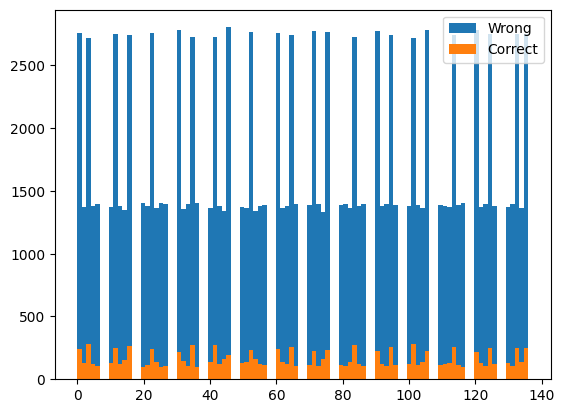

In [44]:
errors = []
corrects = []
for round_idx, rfs in enumerate(random_forests):
    for block_idx, rfc in enumerate(rfs):
        keyround_index = round_idx * BLOCK_WIDTH_B4 + block_idx
        classifications_scores = rfc.predict(traces_test_reduced[round_idx, block_idx])
        for trace_idx, seed in enumerate(seeds_test):
            indices, whitening = chacha_random_b4(seed)
            key_index = indices[keyround_index]
            if (classifications_scores[trace_idx] - whitening[keyround_index]) % 16 != real_keys[0][key_index]:
                errors.append((round_idx, block_idx))
            else:
                corrects.append((round_idx, block_idx))
plt.hist([10 * r + b for r, b in errors], bins=100, label="Wrong")
plt.hist([10 * r + b for r, b in corrects], bins=100, label="Correct")
plt.legend()
plt.show()